In [46]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.stats import nbinom

In [47]:
def SIR_4Group_Euler(p, c_bar, gamma, N_groups, N_i, t_max, stepsize):
    T = np.arange(0, t_max + stepsize, stepsize)
    num_steps = len(T)

    # --- Initial Conditions ---
    S0_i = 0.999 * N_i
    I0_i = 0.001 * N_i
    R0_i = 0.0
 
    S = np.zeros((N_groups, num_steps))
    I = np.zeros((N_groups, num_steps))
    R = np.zeros((N_groups, num_steps))
    S[:, 0] = S0_i
    I[:, 0] = I0_i
    R[:, 0] = R0_i
    
    N_tot = 1
    
    for t_idx in range(1, num_steps):
        S_prev = S[:, t_idx-1]
        I_prev = I[:, t_idx-1]
        R_prev = R[:, t_idx-1]
        I_total = np.sum(I_prev)

        infection_rate_i = (c_bar * p * S_prev / N_i) * I_total
        dS_dt = -infection_rate_i
        dI_dt = infection_rate_i - gamma * I_prev
        dR_dt = gamma * I_prev
        
        S[:, t_idx] = S_prev + dS_dt * stepsize
        I[:, t_idx] = I_prev + dI_dt * stepsize
        R[:, t_idx] = R_prev + dR_dt * stepsize
        
    return S, I, R, T

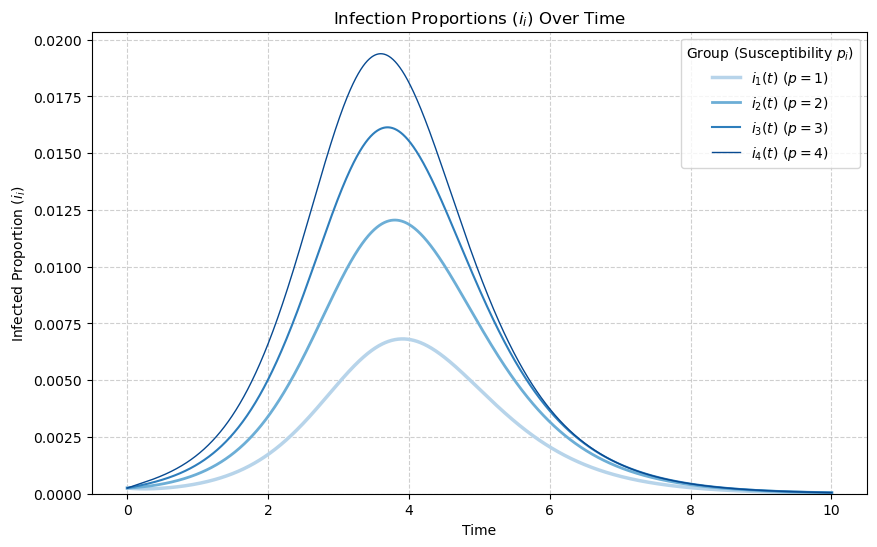

In [48]:
p = np.array([1, 2, 3, 4])  # Susceptibilities
c_bar = 0.45                # Contact rate
gamma = 3.0                 # Recovery rate
N_groups = 4
N_i = 0.25                  # Group size proportion (N_i = 1/4)
t_max = 10                  # Maximum simulation time
stepsize = 0.005            # Time step (Delta t)

S_t, I_t, R_t, T = SIR_4Group_Euler(p, c_bar, gamma, N_groups, N_i, t_max, stepsize)

cmap = plt.get_cmap('Blues_r') 
colors = [cmap(0.1 + 0.2*i) for i in range(4)] 
colors.reverse() # Ensures p=4 is darkest (colors[3]) and p=1 is lightest (colors[0])

plt.figure(figsize=(10, 6))
for i in range(N_groups):
    plt.plot(T, I_t[i], label=f'$i_{i+1}(t)$ ($p={p[i]}$)', 
             color=colors[i], linewidth=2.5 - 0.5*i) # Varying linewidth for visual hierarchy

plt.title('Infection Proportions ($i_i$) Over Time')
plt.xlabel('Time')
plt.ylabel('Infected Proportion ($i_i$)')
plt.legend(title='Group (Susceptibility $p_i$)', loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(0, np.max(I_t) * 1.05)
plt.show()



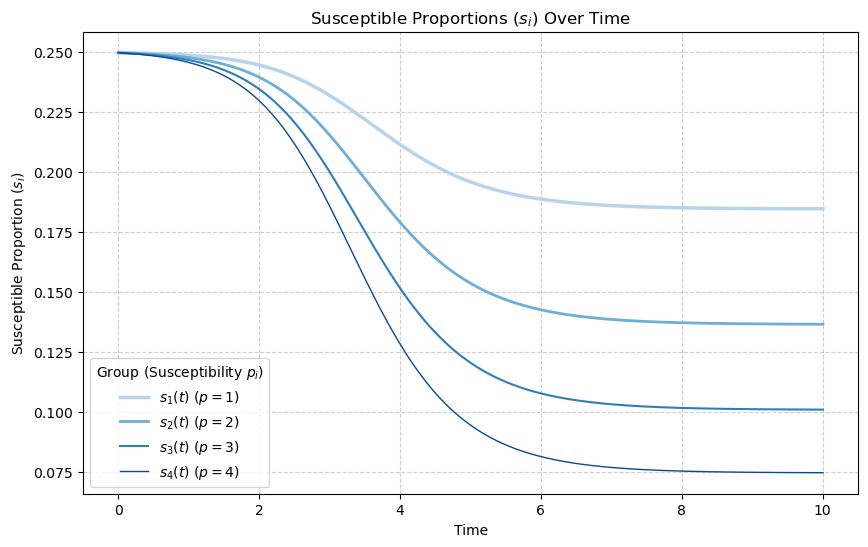

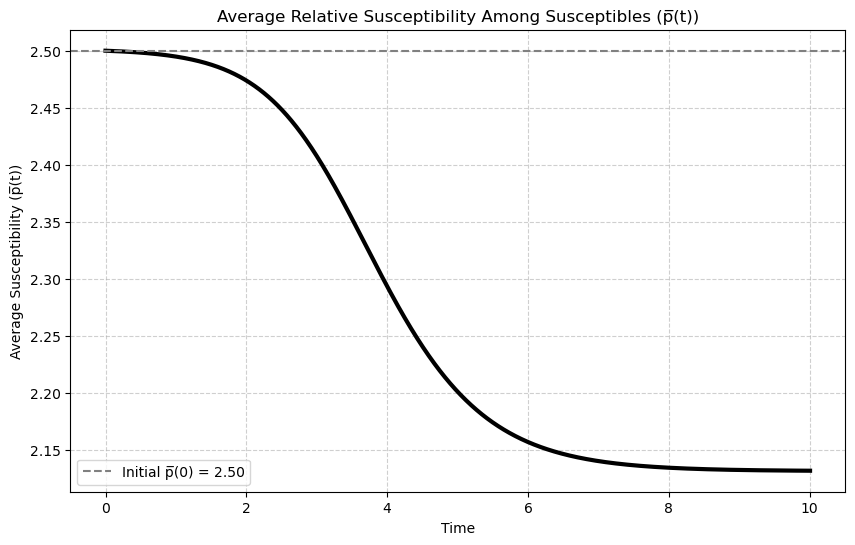

In [49]:
plt.figure(figsize=(10, 6))
for i in range(N_groups):
    plt.plot(T, S_t[i], label=f'$s_{i+1}(t)$ ($p={p[i]}$)', 
             color=colors[i], linewidth=2.5 - 0.5*i)

plt.title('Susceptible Proportions ($s_i$) Over Time')
plt.xlabel('Time')
plt.ylabel('Susceptible Proportion ($s_i$)')
plt.legend(title='Group (Susceptibility $p_i$)', loc='lower left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

numerator = np.sum(p[:, np.newaxis] * S_t, axis=0) 
denominator = np.sum(S_t, axis=0) 
p_bar_t = numerator / denominator
p_bar = 'p\u0305'

plt.figure(figsize=(10, 6))
plt.plot(T, p_bar_t, color='black', linewidth=3)
plt.axhline(y=2.5, color='gray', linestyle='--', label=f'Initial {p_bar}(0) = {p_bar_t[0]:.2f}') 
plt.title(f'Average Relative Susceptibility Among Susceptibles ({p_bar}(t))')
plt.xlabel('Time')
plt.ylabel(f'Average Susceptibility ({p_bar}(t))')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [50]:
import numpy as np
from scipy.stats import nbinom
import matplotlib.pyplot as plt


def estimate_q_and_sizes(R0, k_values, M=100000, G_max=50, Size_max=500):
    results = {}
    
    for k in k_values:
        p_nb = 1 / (1 + R0 / k) 
        n_nb = k
        
        extinct_count = 0
        finite_sizes = []
        
        for _ in range(M):
            current_infections = 1  # Start with 1 case
            total_size = 1
            extinct = False
            
            for gen in range(G_max):
                if current_infections == 0:
                    extinct = True
                    break
                
                # Check for large outbreak cutoff
                if total_size > Size_max:
                    break 
                
                # Draw offspring
                offspring = nbinom.rvs(n=n_nb, p=p_nb, size=current_infections)
                next_infections = np.sum(offspring)
                
                # Update total size and current infections
                total_size += next_infections
                current_infections = next_infections
            
            # Check the final state
            if extinct:
                extinct_count += 1
                finite_sizes.append(total_size)
                
        q_estimate = extinct_count / M
        results[k] = {'q': q_estimate, 'finite_sizes': finite_sizes}
        
    return results

In [51]:
R0 = 3
k_values = [0.1, 0.5, 1.0, 5.0, 10.0]
simulation_results = estimate_q_and_sizes(R0, k_values, M=100000, G_max=50, Size_max=500)
table_data = [(k, simulation_results[k]['q']) for k in k_values]
print("|   k  |   q   |")
print("|------|-------|")
for k, q in table_data:
    print(f"| {k:4.1f} | {q:.3f} |")

|   k  |   q   |
|------|-------|
|  0.1 | 0.838 |
|  0.5 | 0.500 |
|  1.0 | 0.333 |
|  5.0 | 0.121 |
| 10.0 | 0.088 |


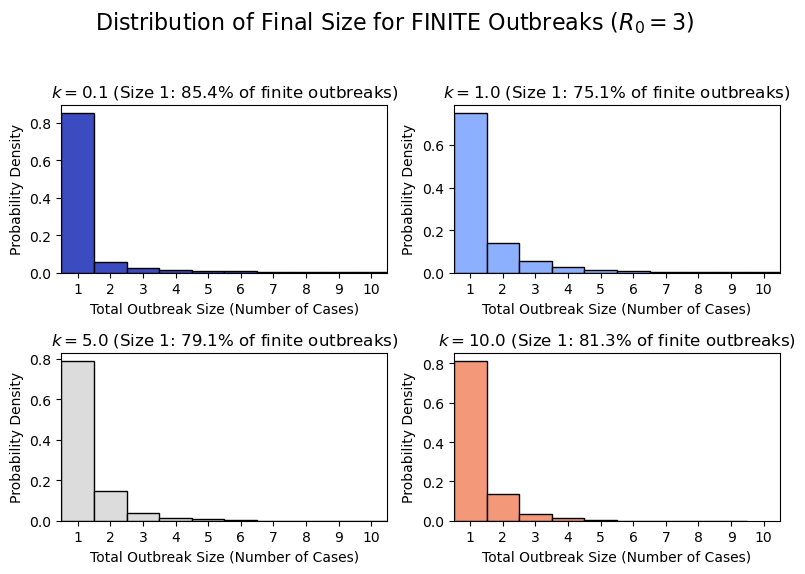

In [52]:
k_hist_values = [0.1, 1.0, 5.0, 10.0]
finite_sizes_data = {k: simulation_results[k]['finite_sizes'] for k in k_hist_values}
    
plt.figure(figsize=(8, 6))

for i, k in enumerate(k_hist_values):
    # Filter out large outliers for clear visualization of the mode
    sizes = np.array(finite_sizes_data[k])
    sizes = sizes[sizes < 20] # Limit size to 20 for clearer visualization of small sizes
    
    plt.subplot(2, 2, i + 1)
    # Binning to center the bars on integer sizes (1, 2, 3...)
    plt.hist(sizes, bins=np.arange(0.5, np.max(sizes) + 1.5, 1), density=True, color=plt.cm.coolwarm(i/len(k_hist_values)), edgecolor='black')
    
    # Calculate the percentage of outbreaks that died with size 1
    percent_size_1 = np.mean(sizes == 1) * 100
    
    plt.title(f'$k = {k}$ (Size 1: {percent_size_1:.1f}% of finite outbreaks)')
    plt.xlabel('Total Outbreak Size (Number of Cases)')
    plt.ylabel('Probability Density')
    plt.xlim(0.5, 10.5)
    plt.xticks(np.arange(1, 11, 1))

plt.suptitle(f'Distribution of Final Size for FINITE Outbreaks ($R_0=3$)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()